CNN-LSTM + EDA Data Augmentation

Implement EDA Functions

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.models import load_model
import json
import nltk
from nltk.corpus import wordnet
import random
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from datasets import load_dataset
import numpy as np


In [50]:
# Ensure that necessary resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalnum()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return ' '.join(new_words)

def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        if new_synonym:
            words.insert(random.randint(0, len(words)), random.choice(list(new_synonym)))
    return ' '.join(words)

def random_swap(sentence, n):
    words = sentence.split()
    length = len(words)
    for _ in range(n):
        idx1, idx2 = random.randint(0, length - 1), random.randint(0, length - 1)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)
    if not new_words:
        return random.choice(words)
    return ' '.join(new_words)

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').replace('-', ' ')
            synonyms.add(synonym.lower()) if synonym != word else synonyms
    return synonyms


[nltk_data] Downloading package wordnet to /Users/jamesso/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jamesso/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Load and Augment the Dataset

In [51]:
# Load the dataset
dataset = load_dataset("ag_news")
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
augmented_texts = []
augmented_labels = []

# Augment data and duplicate labels accordingly
for text, label in zip(train_texts, train_labels):
    # Original text and label
    augmented_texts.append(text)
    augmented_labels.append(label)
    
    # Synonym replacement
    augmented_texts.append(synonym_replacement(text, 2))
    augmented_labels.append(label)
    
    # Random insertion
    augmented_texts.append(random_insertion(text, 2))
    augmented_labels.append(label)
    
    # Random swap
    augmented_texts.append(random_swap(text, 2))
    augmented_labels.append(label)
    
    # Random deletion
    augmented_texts.append(random_deletion(text, 0.25))
    augmented_labels.append(label)

# Now, augmented_texts and augmented_labels are aligned and augmented

Preprocess and Tokenize

In [52]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [53]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(augmented_texts)
sequences = tokenizer.texts_to_sequences(augmented_texts)
#max_length = max(len(x) for x in sequences)  # or use a fixed length
max_length = 180
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare labels for training
labels = np.array(augmented_labels)

# Assuming `augmented_labels` is a list or numpy array of integer class labels
one_hot_labels = to_categorical(augmented_labels, num_classes=4)


In [54]:
print(padded_sequences.shape)
print(one_hot_labels.shape)

(600000, 180)
(600000, 4)


Model Training

In [60]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [63]:
# Define model (as previously setup)
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(), Precision(), Recall()])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 180, 64)           640000    
                                                                 
 conv1d_6 (Conv1D)           (None, 178, 32)           6176      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 89, 32)           0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 4)                 260       
                                                                 
Total params: 671,268
Trainable params: 671,268
Non-trainable params: 0
________________________________________________

In [97]:
history = model.fit(padded_sequences,one_hot_labels, epochs=10, batch_size=256, validation_split=0.15,shuffle=True)

Epoch 1/10
1993/1993 [==============================] - 85s 43ms/step - loss: 0.0058 - accuracy: 0.9981 - f1_score: 0.9981 - precision_5: 0.9982 - recall_5: 0.9981 - val_loss: 0.8843 - val_accuracy: 0.8846 - val_f1_score: 0.8848 - val_precision_5: 0.8852 - val_recall_5: 0.8843
Epoch 2/10
1993/1993 [==============================] - 85s 43ms/step - loss: 0.0028 - accuracy: 0.9991 - f1_score: 0.9991 - precision_5: 0.9991 - recall_5: 0.9991 - val_loss: 1.0153 - val_accuracy: 0.8779 - val_f1_score: 0.8781 - val_precision_5: 0.8787 - val_recall_5: 0.8776
Epoch 3/10
1993/1993 [==============================] - 85s 42ms/step - loss: 0.0029 - accuracy: 0.9991 - f1_score: 0.9991 - precision_5: 0.9991 - recall_5: 0.9991 - val_loss: 0.9332 - val_accuracy: 0.8830 - val_f1_score: 0.8831 - val_precision_5: 0.8836 - val_recall_5: 0.8827
Epoch 4/10
1993/1993 [==============================] - 85s 43ms/step - loss: 0.0025 - accuracy: 0.9991 - f1_score: 0.9992 - precision_5: 0.9992 - recall_5: 0.9991 - 

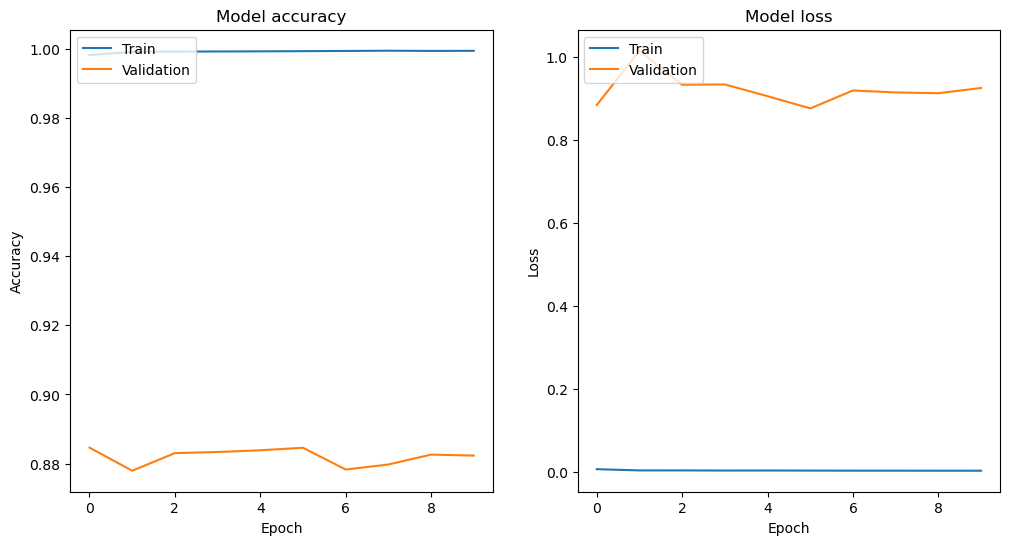

In [98]:
import matplotlib.pyplot as plt

# Assuming `history` is the output from the model.fit() method
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [99]:
model_save_path = "EDA_CNN-LSTM_classifier_model.h5"
model.save(model_save_path) 

# Serialize tokenizer to a JSON string
tokenizer_json = tokenizer.to_json()

# Save the tokenizer JSON string to a file
with open("tokenizer_EDA.json", 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [100]:
EDA_CNN_LSTM = load_model("EDA_CNN-LSTM_classifier_model.h5", custom_objects={'F1Score': F1Score})  # Load the model

# Load tokenizer from JSON file
with open("tokenizer_EDA.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [84]:
print(dataset['test'])
print(max_length)

Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})
180


In [101]:
# Example of preparing test data (replace 'test_texts' with dataset["test"] data)
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

test_labels = np.array(test_labels)
test_one_hot_labels = to_categorical(test_labels, num_classes=4)

# Evaluate the model
loss, accuracy, f1, precision, recall = EDA_CNN_LSTM.evaluate(test_padded_sequences, test_one_hot_labels)
print(f'Test accuracy: {accuracy}, Test F1 Score: {f1}, Precision: {precision}, Recall: {recall}')

2024-05-10 20:06:06.867447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-05-10 20:06:07.067266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 8s 28ms/step - loss: 0.8661 - accuracy: 0.8934 - f1_score: 0.8934 - precision_5: 0.8936 - recall_5: 0.8932
Test accuracy: 0.8934210538864136, Test F1 Score: 0.8933929204940796, Precision: 0.8936282396316528, Recall: 0.8931578993797302
